<a href="https://colab.research.google.com/github/AmbiTyga/Bio-VI-BERT/blob/main/ProtoNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prototypical Netwoks on the CDC Parasitic dataset



*   `Author:` Ambesh Shekhar
*   `Date:` 03/2021
*   `Credit:` 
  - Main source of inspiration [https://github.com/jakesnell/prototypical-networks](https://github.com/jakesnell/prototypical-networks)
  - Derived from [https://github.com/cnielly/prototypical-networks-omniglot](https://github.com/cnielly/prototypical-networks-omniglot)


##Import libraries

In [ ]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset.7z
!7z x /content/Dataset.7z

--2021-03-16 16:35:03--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22159364 (21M) [application/octet-stream]
Saving to: ‘Dataset.7z’

Dataset.7z          100%[===================>]  21.13M  --.-KB/s    in 0.1s    

2021-03-16 16:35:03 (221 MB/s) - ‘Dataset.7z’ saved [22159364/22159364]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 22159364 bytes (22 MiB)

Extracting archive: /content/Dataset.7z
--
Path = /content/Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
!rm Parasites -r

In [ ]:
data = pd.read_csv("/content/parasite.csv")

In [ ]:
data['species'] = data['species'].str.replace('.','')

In [ ]:
for path in data['species'].unique():
  os.makedirs(f"/content/Parasites/{path}")

In [ ]:
t = []
t.append(torchvision.transforms.Compose([
        torchvision.transforms.GaussianBlur(5),
        torchvision.transforms.RandomPerspective(p=1)]))

t.append(torchvision.transforms.Compose([
        torchvision.transforms.GaussianBlur(5),
        torchvision.transforms.RandomVerticalFlip(p=1)]))


t.append(torchvision.transforms.Compose([
        torchvision.transforms.Grayscale(3),
        torchvision.transforms.RandomVerticalFlip(p=1)]))

t.append(torchvision.transforms.Compose([
        torchvision.transforms.Grayscale(3),
        torchvision.transforms.RandomPerspective(p=1)]))

In [ ]:
def transform_save(data,index):
  img = Image.open(data[8])
  images = [img]
  images.extend((T(img) for T in t))
  for i, image in enumerate(images):
    image.convert('RGB').save(f"/content/Parasites/{data[3]}/T_{i}_{index}.jpg")
  values = [[data[0],data[1],data[2],data[3],data[4],data[5],f"/content/Parasites/{data[3]}/T_{i}_{index}.jpg"] for i in range(len(images))]
  return values


In [ ]:
new = []
for i in data.index:
  new.extend(transform_save(data.iloc[i,:].values,index =i))

In [ ]:
data = pd.DataFrame(new,columns=['phylum','class','genus','species','form','sample','img_path'])

In [ ]:
data['species'].value_counts()

Plasmodium malariae          185
Cyclospora cayetanensis      185
Giardia duodenalis           180
Ascaris lumbricoides         180
Plasmodium vivax             180
Entamoeba histolytica        180
Plasmodium falciparum        180
Plasmodium ovale             170
Strongyloides stercoralis    110
Dibothriocephalus latus      105
Trichuris Trichuria           95
Enterobius vermicularis       90
Ancyclostoma sp               85
Toxocara canis                85
Sarcocystis sp                80
Cryptosporidium sp            80
Plasmodium knowlesi           75
Hymenolepis nana              70
Toxoplasma gondii             65
Trichinella sp                65
Name: species, dtype: int64

In [ ]:
#Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


##Create samples

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data,test_size = 0.25, stratify = data['species'])


In [ ]:
transform = torchvision.transforms.Compose([
                                            torchvision.transforms.Resize((224,224)),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                            torchvision.transforms.Resize((45,45))
])

In [ ]:
def extract_sample(n_way, n_support, n_query, data):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  sample = []
  K = np.random.choice(data['species'].unique(), n_way, replace=False)
  for cls in K:
    datax_cls = data['img_path'][data['species'] == cls].values
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample_cls = [transform(Image.open(cls)).numpy() for cls in sample_cls]
    sample.append(sample_cls)

  sample = np.array(sample)
  sample = torch.from_numpy(sample)
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

In [ ]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

As an example, let's pick a sample and display it

*   n_way = 8
*   n_support = 5
*   n_query = 5




In [ ]:
sample_example['images'].shape

torch.Size([8, 10, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


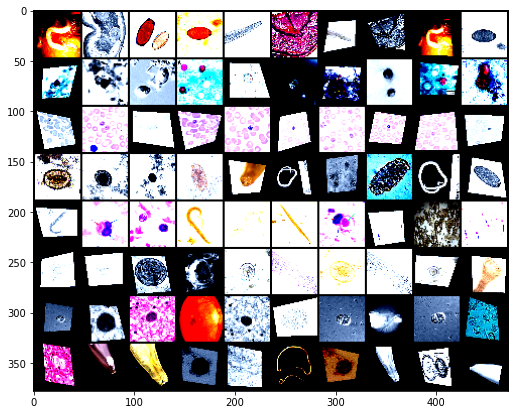

In [ ]:
sample_example = extract_sample(8, 5, 5, train_data)
display_sample(sample_example['images'])

In [ ]:
sample_example['images'].shape

torch.Size([8, 10, 3, 45, 45])

##Build model

Paper: [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

The embedding part takes a (28x28x3) image and returns a column vector of length 64. The image2vector function is composed of 4 modules. Each module comprises a 64-filter 3 × 3 convolution, a batch normalization layer, a ReLU nonlinearity and a 2 × 2 max-pooling layer. 

When applied to the 28 × 28 Omniglot images this architecture results in a 64-dimensional output space.

In [ ]:
def load_protonet_conv(**kwargs):
  """
  Loads the prototypical network model
  Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
  Returns:
      Model (Class ProtoNet)
  """
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )
    
  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    nn.Flatten()
    )
    
  return ProtoNet(encoder)

In [ ]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the images in sample
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    self.encoder = encoder.cuda()

  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = sample['images'].cuda()
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
   
    #target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()
   
    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
   
    z = self.encoder.forward(x)
    z_dim = z.size(-1) #usually 64
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]

    #compute distances
    dists = euclidean_dist(z_query, z_proto)
    
    #compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
   
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
   
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

In [ ]:
def euclidean_dist(x, y):
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

##Train

In [ ]:
from tqdm import tqdm_notebook
from tqdm.notebook import tnrange

In [ ]:
def train(model, optimizer, data, n_way, n_support, n_query, max_epoch, epoch_size):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  #divide the learning rate by 2 at each epoch, as suggested in paper
  model = model.cuda()
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop
  model.train()
  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      sample = extract_sample(n_way, n_support, n_query, data)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()

In [ ]:
model = load_protonet_conv(
    x_dim=(3,45,45),
    hid_dim=64,
    z_dim=64,
    )

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 20
n_support = 5
n_query = 5

max_epoch = 2
epoch_size = 2000

train(model, optimizer, train_data, n_way, n_support, n_query, max_epoch, epoch_size)


Epoch 1 -- Loss: 0.6297 Acc: 0.8321



Epoch 2 -- Loss: 0.0009 Acc: 0.9998


##Test

In [ ]:
def test(model, test, n_way, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = extract_sample(n_way, n_support, n_query, test)
    loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [ ]:
n_way = 20
n_support = 5
n_query = 5


test_episode = 1000

test(model, val_data, n_way, n_support, n_query, test_episode)


Test results -- Loss: 2.4468 Acc: 0.4832


##Test on specific example

Let's test the model on a specific example to visualize how well does it label the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


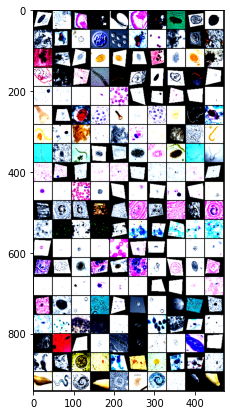

In [ ]:
my_sample = extract_sample(n_way, n_support, n_query, val_data)
display_sample(my_sample['images'])

In [ ]:
my_loss, my_output = model.set_forward_loss(my_sample)

In [ ]:
print(f"Acc:{my_output['acc']} , Loss:{my_output['loss']}")

Acc:0.4599999785423279 , Loss:2.5393450260162354
